In [1]:
What does this notebook comprise of?

This notebook has three parts: 

Goal: The goal is to predict reviews_score.

1.Building a model using only the text part of the reviews.
2.Building a model using only the meta information.
3.Building a model by concatenating the outcome of 1 and 2 to predict reviews_score
    

In [106]:
import pandas as pd

In [7]:
#converting a json file into a csv # It worked. Yay!


def json_csv(filename):
    data = [json.loads(line) for line in open(filename, 'r')]
    return pd.DataFrame(data)

    
    

In [9]:
#converting the json file and storing the result in df
df=json_csv('/Users/chidam/Desktop/yelp_academic_dataset_review.json')


In [10]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [11]:
#total number of records in the dataset
len(df)

8021122

In [12]:
#importing necessary packages

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

Using TensorFlow backend.


In [13]:
#we are binning the values in the column: stars and then renaming the categories as bad, average, and good.

bins = [0,1,3,5]
review_names = ['bad', 'average', 'good']
df['reviews_score'] = pd.cut(df['stars'], bins, labels=review_names)


In [14]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,reviews_score
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16,average
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52,bad
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11,good
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52,bad
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57,good


In [17]:
#to calculate the percentage of null #looks like there are no null values
df.isnull().sum() * 100 / len(df)


review_id        0.0
user_id          0.0
business_id      0.0
stars            0.0
useful           0.0
funny            0.0
cool             0.0
text             0.0
date             0.0
reviews_score    0.0
dtype: float64

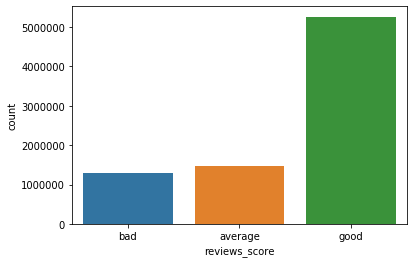

In [19]:
#let's check the distribution of the reviews per category

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.countplot(x='reviews_score', data=df)

#The reviews with ratings 4 and 5 outrank reviews with other ratings 

In [20]:
#Let's select only 50000 records in the dataset for easier computing. Note: the purpose of this notebook is to demonstrate 
#building multi-input models using the Keras Functional API.

df_selected=df[:50000]





In [21]:
len(df_selected)

50000

In [23]:
#preprocessing text by removing multiple spaces, punctuations, and single characters
def preprocess_text(sen):

    # Remove punctuations
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [24]:
#process the text by passing as an input into the above function: preprocess_text

X = []
sentences = list(df_selected["text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = df_selected['reviews_score']

In [26]:
#label encoding the values in the column: "reviews_score"

from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

Y = label_encoder.fit_transform(y)

In [27]:
Y

array([0, 1, 2, ..., 2, 0, 1])

In [31]:
#divide the dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [34]:
# we can convert both the training and test labels into one-hot encoded vectors:

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [36]:
y_test

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [39]:
#let's check a review

X_train[0]

'This place has been fantastic addition to Chambana It perfect for date nights bachelorette parties random get togethers or even company team building events brought my wife here for our third anniversary and we had blast We brought our own wine you can bring appetizers too if you want and ended up with two beautiful renditions of wonderful painting The instructor is super friendly and very talented It on the second floor of the building and was little hard to find at first but there was guy waiting downstairs directing people up to the second floor Much appreciated '

In [40]:
#considering only 5000 words as I am going to use my computer's CPU for computing

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [108]:
#fixing the max length of sentences as 200 here. Alternative way is to loop through every sentence and find the sentence
#with maximum length. clicked run by mistake and therefore the following error

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

ValueError: invalid literal for int() with base 10: 'review_id'

In [42]:
X_train

array([[  15,   28,   88, ...,    0,    0,    0],
       [  32,  541,  272, ...,    0,    0,    0],
       [  29, 2028,   17, ...,    8,   67,  479],
       ...,
       [  38,    7,   32, ...,    0,    0,    0],
       [  89,   36,   14, ...,  207,    0,    0],
       [  70, 1048,    3, ...,    0,    0,    0]], dtype=int32)

In [ ]:
#we need to load the built-in GloVe word embeddings

# from numpy import array
# from numpy import asarray
# from numpy import zeros

# embeddings_dictionary = dict()

# for line in glove_file:
#     records = line.split()
#     word = records[0]
#     vector_dimensions = asarray(records[1:], dtype='float32')
#     embeddings_dictionary [word] = vector_dimensions

# glove_file.close()

In [55]:
#let use the GloVe word embeddings to use the pretrained embeddings on our text

embeddings_index = {};
with open('/Users/chidam/Desktop/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size, 100));
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [56]:
embeddings_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [ 0.89551002, -0.078076  , -0.27158001, ...,  0.42851001,
        -0.78353   , -0.63169998],
       [-0.41411   , -0.087855  ,  0.48895001, ..., -0.019089  ,
        -0.63259   , -0.0091977 ],
       [-0.20149   ,  0.061445  , -0.39269999, ...,  0.0015361 ,
        -0.31996   , -0.061939  ]])

In [57]:
#building an LSTM layer and passing the embedded text as input 

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embeddings_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(3, activation='softmax')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [58]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          4780900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 4,898,535
Trainable params: 117,635
Non-trainable params: 4,780,900
_________________________________________________________________
None


In [66]:
#couldn't visualize the model's structure detailing layers, input, and output
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# keras.utils.vis_utils.pydot = pyd

def visualize_model(model):
    return SVG(model_to_dot(model).create(prog='dot', format='svg'))

# plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)
visualize_model(model)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [68]:
#Of course the validation accuracy is pretty close to the training accuracy, therefore the model is not overfitting.
#It's possible to improve the scores and reduce the loss much lower if we train the model for many epochs. But this is
#only a demonstration attempt skipping that part for now. Also can tune the hyperparameters for a better performance.

history = model.fit(X_train, y_train, batch_size=128, epochs=2, verbose=1, validation_split=0.2)



Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 208s 7ms/step - loss: 0.8456 - acc: 0.6719 - val_loss: 0.8267 - val_acc: 0.6755
Epoch 2/2
32000/32000 [==============================] - 196s 6ms/step - loss: 0.8390 - acc: 0.6696 - val_loss: 0.8664 - val_acc: 0.6699


In [69]:

score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])



10000/10000 [==============================] - 23s 2ms/step
Test Score: 0.8699560987472534
Test Accuracy: 0.6662999987602234


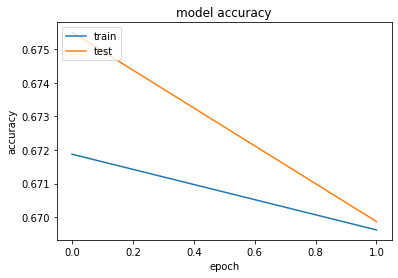

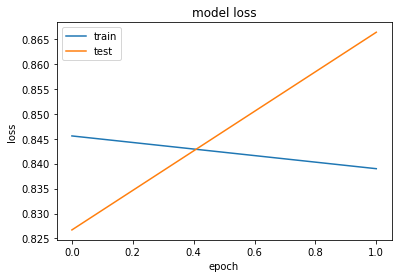

In [70]:
#let's visualize the accuracy/loss of training and validation sets

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()



In [ ]:
------------------------------------------------------------------------------------------------------------------------------------


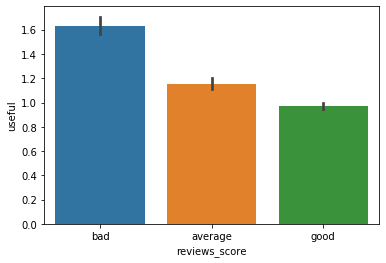

In [71]:

#Let's now create a model to predict reviews_score using only the meta info, i.e., columns: cool, funny, and useful

#Plot of average counts for useful Vs. reviews_score

import seaborn as sns
sns.barplot(x='reviews_score', y='useful', data=df_selected)


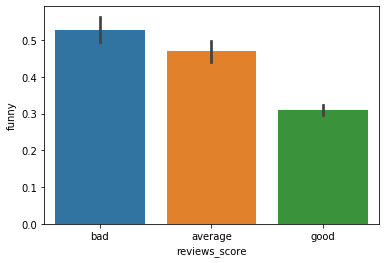

In [72]:
#Plot of average counts for funny Vs. reviews_score

sns.barplot(x='reviews_score', y='funny', data=df_selected)

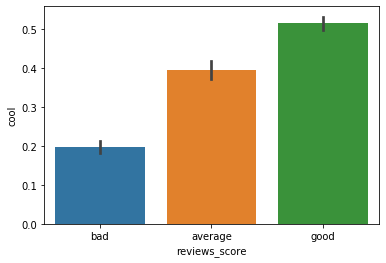

In [73]:
#Plot of average counts for cool Vs. reviews_score

sns.barplot(x='reviews_score', y='cool', data=df_selected)

In [ ]:
More research needed!

Not sure: does the correlation between the meta information and target column matter while trying to build a model using
the meta info and predicting the target column values?
    
    
    

In [74]:
#Let's get the necessary columns as input

df_selected_meta = df_selected[['useful', 'funny', 'cool']]

X = df_selected_meta.values

y = df_selected['reviews_score']


In [75]:
#splitting the dataset

from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [76]:
#building up the model layers

input2 = Input(shape=(3,))
dense_layer_1 = Dense(10, activation='relu')(input2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
output = Dense(3, activation='softmax')(dense_layer_2)

model = Model(inputs=input2, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [77]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 33        
Total params: 183
Trainable params: 183
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
#to print the model structure - not working yet
# from keras.utils import plot_model
# plot_model(model, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [80]:
#training the model

history = model.fit(X_train, y_train, batch_size=16, epochs=2, verbose=1, validation_split=0.2)


Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 6s 198us/step - loss: 0.8535 - acc: 0.6665 - val_loss: 0.8180 - val_acc: 0.6746
Epoch 2/2
32000/32000 [==============================] - 4s 117us/step - loss: 0.8155 - acc: 0.6768 - val_loss: 0.8166 - val_acc: 0.6750


In [81]:
#evaluating the model's performance

score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

10000/10000 [==============================] - 0s 40us/step
Test Score: 0.8277640296459198
Test Accuracy: 0.6718999743461609


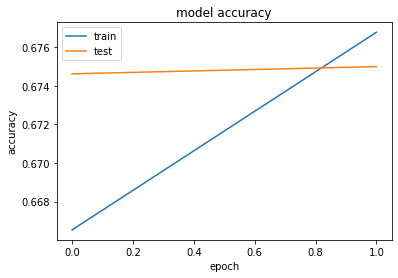

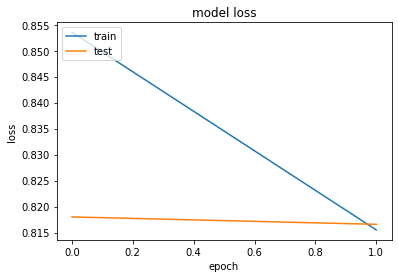

In [82]:
#visualizing accuracy/loss of train and validation sets

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()



In [83]:
#now on to creating a model with multiple inputs: 
#1. review texts as input
#2. meta info as input

X = df_selected.drop('reviews_score', axis=1)

y = df_selected['reviews_score']

In [85]:
#Split the dataset into train and test

from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)




In [88]:
X_train

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
39087,pOkCvmDuGtswQyVYXKRnpQ,Yximlvn0cfb3yVDaLuXDxw,sfn4UtTZOjGo0hIWBa48uw,5.0,0,0,0,This place has been a fantastic addition to Ch...,2013-08-06 17:58:37
30893,u4_QHiptHl7h4wIApjo-ow,vTzj4Hc8PZ-MJF_SPYjmxg,7j0kor_fkeYhyEpXh4OpnQ,2.0,1,3,0,Very average breakfast food. Everything came o...,2015-09-10 15:08:52
45278,fcwn9ihdvYVNKmP15aEtpg,FFWWihGdhushG19K5-G06A,LHXisknIbUy_XtdEQc7x9w,1.0,0,1,0,Recently ran into an issue in Vegas that left ...,2016-06-01 16:18:01
16398,-wOb5XYjSKoY6tlENJw7Wg,rgA-UGIQl1r9Z5mZUvNZaQ,u2q_84hHvKGl5hKnAE7zNw,4.0,1,0,1,Really great sushi. I'm an avid sushi lover fr...,2008-12-04 03:53:36
13653,bUhExeW-P3F5tTbjFoJNWg,ABby5dSGjgDLri8HiSodGA,q2GzUNQj998GSC8IhkN9hg,5.0,0,0,0,First time trying Hummus and man was I blown a...,2018-06-26 21:48:34
...,...,...,...,...,...,...,...,...,...
11284,h5NQgQxqOUHA2qCLLTC5Ew,Vmsmf4i096q9feBgp4CuXA,fmyo8-JBOu5bjczEsLJyBA,4.0,12,10,12,"Great sports bar. Lots of nice big TVs, yummy...",2010-01-11 17:58:33
44732,u0QPsLqEbLiQHP_Nt3F34A,kJsMFBdQ_Do67u3lpvaujA,aEtbXqbkf2BnwEVWQ2yjUw,4.0,0,0,0,I was pretty excited to try this place out! Fo...,2018-03-24 23:51:42
38158,gxUO5mNAX644l7aAdA99eA,JqE0wUQV900w6kgnAvsptw,EjzMHfwqAmj7BgdzQjquRQ,5.0,0,0,0,Service is very good I knew it would be great ...,2018-05-10 01:05:41
860,0ekTNzjUf-WViTRqGPRKOQ,EZ6RX5HMD3DXRxZjF2j6VQ,KTPRYqiFdLowAUEAnN7e3g,4.0,0,0,0,Came here with husband and bonus daughter whil...,2015-07-03 20:07:31


In [89]:
len(X_train)

40000

In [90]:
len(X_test)

10000

In [86]:

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


In [87]:

X1_train = []
sentences = list(X_train["text"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))
    

In [91]:
X1_test = []
sentences = list(X_test["text"])
for sen in sentences:
    X1_test.append(preprocess_text(sen))

In [92]:
#preprocessing text by adjusting the size of the sentences and post padding them

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

In [93]:
#converting review text into vectors using Glove pretrained word embeddings  

embeddings_index = {};
with open('/Users/chidam/Desktop/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size, 100));
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [94]:
#considering the second input from meta info columns:'useful', 'funny', 'cool'

X2_train = X_train[['useful', 'funny', 'cool']].values
X2_test = X_test[['useful', 'funny', 'cool']].values


In [102]:
X2_train

array([[0, 0, 0],
       [1, 3, 0],
       [0, 1, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [95]:
#defining the input structure

input_1 = Input(shape=(maxlen,))

input_2 = Input(shape=(3,))


In [97]:
# Let's now create the first submodel that accepts data from first input layer: here an LSTM model is used to receive the 
#embedded input
#note we are not using Sequential() here in the model design

embedding_layer = Embedding(vocab_size, 100, weights=[embeddings_matrix], trainable=False)(input_1)
LSTM_Layer_1 = LSTM(128)(embedding_layer)



In [98]:
# Observe the dense layer to receive the second input and another dense layer to output the input received 

dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)


In [99]:
# Notice the dense layer that accepts the concatenated inputs and another dense layer followed by for the output.

concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(3, activation='softmax')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)


In [100]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())



Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 100)     4780900     input_5[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 10)           40          input_6[0][0]                    
____________________________________________________________________________________________

In [ ]:


# from keras.utils import plot_model
# plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)


In [103]:
#validation loss must get lesser per epoch, not strictly per epoch, but the accuracy has to be improved and the loss 
#need to be decreased 


history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=2, verbose=1, validation_split=0.2)



Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 207s 6ms/step - loss: 0.8216 - acc: 0.6701 - val_loss: 0.7859 - val_acc: 0.6693
Epoch 2/2
32000/32000 [==============================] - 194s 6ms/step - loss: 0.7651 - acc: 0.6686 - val_loss: 0.8297 - val_acc: 0.6724


In [104]:

score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])



10000/10000 [==============================] - 24s 2ms/step
Test Score: 0.8405496852874755
Test Accuracy: 0.6682000160217285


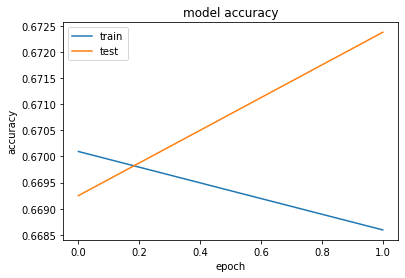

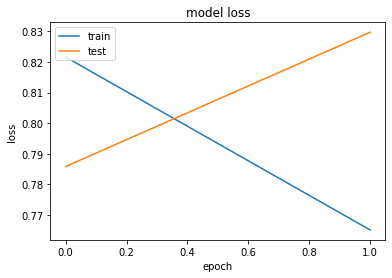

In [105]:
#visualizing accuracy/loss

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()



In [ ]:
Observation:
    
As obvious it is from the above plots the model is underfitting the training set while performing good on the test set.

Also meta info is not as useful as the text in predicting the reviews_score

